<center style="font-weight:bold;font-size:26px">Pericolo - Marker Detection - Aruco </center>

# Setup

## Imports

In [2]:
import os
import sys

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2 import aruco
import pandas as pd
from skimage import feature, color, transform, io
from scipy.spatial import distance as dist
from PIL import Image, ImageDraw

In [4]:
sys.path.append(os.path.join(os.path.abspath(''), '.'))

## Global Variables

In [5]:
ROOT_FOLDER = os.path.join(os.path.abspath(''), '..')
DATA_FOLDER = os.path.join(ROOT_FOLDER, 'data')
IMG_FOLDER = os.path.join(DATA_FOLDER, 'img')
ANNOT_FOLDER = os.path.join(DATA_FOLDER, 'annotations')

# Functions definition

In [6]:
def read_img(filename, engine='cv'):
    if engine == 'cv':
        img = cv2.imread(filename)
    elif engine == 'skimage':
        img = io.imread(filename)
    return img

In [7]:
def get_img(df, idx, engine='cv'):
    print(df.loc[idx].file)
    return read_img(os.path.join(IMG_FOLDER, df.loc[idx].file), engine=engine)

## Plot functions

In [8]:
def imshow(img, figsize=(6, 6), cmap=None):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.show()

In [9]:
def imshow_masked(img, mask, figsize=(6,6), factor=0.3):
    fig = plt.figure(figsize=figsize)
    aux_img = img.astype(float)
    aux_mask = np.expand_dims(mask.astype(float)*(1-factor) + factor, axis=-1)
    drk_img = (aux_img * aux_mask).astype(np.uint8)
    plt.imshow(drk_img)
    plt.show()

## Mask generation

In [10]:
def polygon_to_mask(width, height, polygon):
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    return np.array(img)

In [11]:
def IoU(mask_a, mask_b):
    I = mask_a * mask_b
    U = (mask_a + mask_b).clip(max=1)
    IOU = I.sum() / U.sum()
    return IOU

In [12]:
def inclusion_ratio(small_mask, large_mask):
    I = small_mask * large_mask
    ratio = I.sum() / small_mask.sum()
    return ratio

## Detector functions

In [13]:
def drawer_detector(QueryImgBGR, trainImg, goodMatch, trainKP, queryKP, force_true = False):
    if (len(goodMatch)>=MIN_MATCH_COUNT) or force_true:
        tp=[]
        qp=[]
        for m in goodMatch:
            tp.append(trainKP[m.trainIdx].pt)
            qp.append(queryKP[m.queryIdx].pt)
        tp,qp=np.float32((tp,qp))
        H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
        h,w=trainImg.shape
        trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
        queryBorder=cv2.perspectiveTransform(trainBorder,H)
        cv2.polylines(QueryImgBGR,[np.int32(queryBorder)],True,(0,255,0),5)
        print("Match Found")
        return trainBorder, queryBorder
    else:
        print("Not Enough match found-")
        print(len(goodMatch),MIN_MATCH_COUNT)
        return None

In [14]:
def train_sift(train_img, compute_img=False, fsize=(8,8)):
    FLANN_INDEX_KDITREE=0
    flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
    flann=cv2.FlannBasedMatcher(flannParam,{})
    
    # Training
    sift_detector=cv2.xfeatures2d.SIFT_create()
    sift_trainImg= train_img.copy()
    sift_trainKP,sift_trainDesc=sift_detector.detectAndCompute(sift_trainImg,None)
    if compute_img:
        sift_trainImg1=cv2.drawKeypoints(sift_trainImg,sift_trainKP,None,(255,0,0),4)
        print("Detector Result on Train Image")
        imshow(sift_trainImg1, figsize=fsize)
        
    return sift_detector, sift_trainKP, sift_trainDesc, flann

In [15]:
def query_sift(query_img, sift_detector, sift_trainDesc, flann):
    #Querying
    sift_QueryImgBGR = query_img.copy()
    sift_QueryImg=cv2.cvtColor(sift_QueryImgBGR,cv2.COLOR_BGR2GRAY)
    sift_queryKP,sift_queryDesc=sift_detector.detectAndCompute(sift_QueryImg,None)
    sift_matches=flann.knnMatch(sift_queryDesc,sift_trainDesc,k=2)
    sift_goodMatch=[]
    
    for m,n in sift_matches:
        if(m.distance<0.75*n.distance):
            sift_goodMatch.append(m)
    print(f"Found matches: {len(sift_goodMatch)}")
    return sift_goodMatch, sift_queryKP, sift_queryDesc

In [16]:
def compute_detector_corners(trainImg, goodMatch, trainKP, queryKP, force_true = False):
    if (len(goodMatch)>=MIN_MATCH_COUNT) or force_true:
        tp=[]
        qp=[]
        for m in goodMatch:
            tp.append(trainKP[m.trainIdx].pt)
            qp.append(queryKP[m.queryIdx].pt)
        tp,qp=np.float32((tp,qp))
        H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
        h,w=trainImg.shape
        trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
        queryBorder=cv2.perspectiveTransform(trainBorder,H)
        return trainBorder, queryBorder
    else:
        print("Not Enough match found")
        return [], [] 

In [17]:
def draw_detector_borders(image, queryBorder, color=(0,255,0), thickness=5, draw=True, figsize=(8,8)):
    QueryImgBGR = image.copy()
    cv2.polylines(QueryImgBGR,[np.int32(queryBorder)],True,color,thickness)
    if draw:
        imshow(QueryImgBGR, figsize=figsize)
    return QueryImgBGR

## Warp functions

In [18]:
def vector_representation(lines):
    locations = []
    directions = []
    strengths = []
    
    # For each detected line of 2 points
    for a,b in lines:
        a,b = np.array(a), np.array(b)
        locations.append((a + b) / 2) # generate the location as the middle point
        directions.append(b - a) # compute the direction vector
        strengths.append(np.linalg.norm(b - a)) # compute the strength as the norm
    
    locations = np.array(locations)
    directions = np.array(directions)
    strengths = np.array(strengths)
    
    directions = np.array(directions) / np.linalg.norm(directions, axis=1)[:, np.newaxis] # normalize the directions
    
    return (locations, directions, strengths)

In [19]:
def to_homogenous_geometry(locations, directions, strengths):
    normals = np.zeros_like(directions) # Compute the edglets normal vector
    normals[:, 0] = directions[:, 1]
    normals[:, 1] = -directions[:, 0]
    p = -np.sum(locations * normals, axis=1)
    lines = np.concatenate((normals, p[:, np.newaxis]), axis=1) # Create the 3rd dimension representing the same point
    return lines

In [20]:
def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

In [21]:
def infer_warp_shape(image, vp1, vp2, clip=False, clip_factor=3):
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)
    
    max_x = int(max_x)
    max_y = int(max_y)
    
    return max_x, max_y

In [22]:
def warp_image(image, vp1, vp2, clip=True, clip_factor=3):
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    # Create an Offset matrix
    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    # Generate the final Homography matrix
    # by applying the offset on top of the previous matrices
    final_homography = np.dot(T, inter_matrix)

    # Generate the transformed image
    warped_img = transform.warp(image, np.linalg.inv(final_homography),
                                output_shape=(max_y, max_x))
    return warped_img

In [23]:
def ransac(locations, directions, strengths, num_ransac_iter=2000, threshold_inlier=5):
    lines = to_homogenous_geometry(locations, directions, strengths) # convert to homogenous geometry

    num_pts = strengths.size

    arg_sort = np.argsort(-strengths)
    first_index_space = arg_sort[:num_pts // 5] # Select the top 20 percentile
    second_index_space = arg_sort[:num_pts // 2] # Select the top 50 percentile

    best_model = None
    best_votes = np.zeros(num_pts)

    # Sampling process
    for ransac_iter in range(num_ransac_iter):
        ind1 = np.random.choice(first_index_space) # Sample a line from the top 20 percentile
        ind2 = np.random.choice(second_index_space) # Sample a line from the top 50 percentile

        l1 = lines[ind1]
        l2 = lines[ind2]

        # In Homogenous geometry the cross-product (vectot product)
        # represents the intersection points between two vectors
        current_model = np.cross(l1, l2)
        
        # In case of degeneracy
        # e.g colinearity between l1 and l2
        # e.g sampling where l1 and l2 are the same line
        if np.sum(current_model**2) < 1 or current_model[2] == 0:
            # Force resampling
            continue

        # Represent Vanishing Point (Intersection Point) in (X, Y, 1) Initial Plane
        vp = current_model[:2] / current_model[2]
        
        # For each edgelet compute the angle between the direction vector
        # and the vector defined as edgelet location minus vanishing point
        est_directions = locations - vp
        dot_prod = np.sum(est_directions * directions, axis=1)
        abs_prod = np.linalg.norm(directions, axis=1) * np.linalg.norm(est_directions, axis=1)
        abs_prod[abs_prod == 0] = 1e-5
        threshold_inlier = 5
        cosine_theta = dot_prod / abs_prod
        theta = np.arccos(np.abs(cosine_theta))
        
        # Consider for scoring only the edglets within a range of +/- threshold_inlier
        theta_thresh = threshold_inlier * np.pi / 180
        # The score is equal to the sum of edgelet's strength falling in the threshold range
        current_votes = (theta < theta_thresh) * strengths
        
        # In case the new model is better, replace the old one
        if current_votes.sum() > best_votes.sum():
            best_model = current_model
            best_votes = current_votes
            print("Current best model has {} votes at iteration {}".format(
                current_votes.sum(), ransac_iter))
    return best_model

In [24]:
def marker_position_in_projection(image, vp1, vp2, aruco_borders,clip=True, clip_factor=3):
    """Warp the perspective of an image given a set of vanishing points
    
    Args:
    -----
        image (np.array): Image to Warp (`RGB`/`BGR`/`GRAYSCALE`)
        vp1 (np.array): First vanishing point description
        vp2 (np.array): Second vanishing point description
        clip (bool, optional): Whether to clip or not the image. Defaults to False.
        clip_factor (int, optional): In case of clipping, which factor to apply. Defaults to 3.
    
    Returns:
    --------
        np.array: Warped image

    Note:
    -----
    In case you do not activate the clipping and the image has a strong perspective,
    the resulting warped image might have a huge size. Hence, it might slow the computation.
    """
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    # Create an Offset matrix
    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    # Generate the final Homography matrix
    # by applying the offset on top of the previous matrices
    final_homography = np.dot(T, inter_matrix)


    marker_edges = [
        [aruco_borders[0][1], aruco_borders[1][1], aruco_borders[2][1], aruco_borders[3][1]],
        [aruco_borders[0][0], aruco_borders[1][0], aruco_borders[2][0], aruco_borders[3][0]],
        [1, 1, 1, 1]
    ]

    # Generate the marker position in the new projection
    marker_positions = np.dot(final_homography, marker_edges)
    return marker_positions

# Main Code

## Initialisation

Under the `data` folder we have created a `board` folder to distinguish sample images with board in it

In [25]:
os.listdir(os.path.join(DATA_FOLDER, 'board'))

['20200108_023705.jpg',
 '20200108_023539.jpg',
 '20200108_023529.jpg',
 '20200108_023845.jpg',
 '20200108_023700.jpg',
 '20200108_023558.jpg',
 '20200108_023613.jpg',
 '20200108_023639.jpg',
 '20200108_023823.jpg',
 '20200108_023830.jpg',
 '20200108_023603.jpg',
 '20200108_023753.jpg',
 '20200108_023550.jpg',
 '20200108_023544.jpg',
 '20200108_023626.jpg',
 '20200108_023632.jpg',
 '20200108_023750.jpg',
 '20200108_023745.jpg',
 '20200108_023619.jpg',
 '20200108_023838.jpg',
 '20200108_023718.jpg',
 '20200108_023726.jpg']

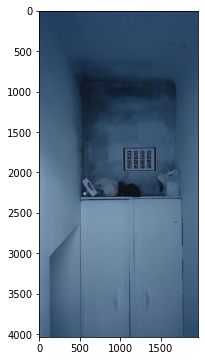

In [26]:
# Good SIFT + Aruco '20200108_023705.jpg', '20200108_023700.jpg', '20200108_023613.jpg', '20200108_023626.jpg', '20200108_023539.jpg', 20200108_023529
# Less Acurate Warp '20200108_023845.jpg', '20200108_023558.jpg', '20200108_023823.jpg', '20200108_023830.jpg', '20200108_023603.jpg', '20200108_023550.jpg', '20200108_023544.jpg', '20200108_023632.jpg', '20200108_023619.jpg', '20200108_023838.jpg'
# Bad SIFT Good Aruco: '20200108_023753.jpg', '20200108_023750.jpg', '20200108_023745.jpg'
# Bad Aruco Good Sift '20200108_023639.jpg'
# No detection: 
image = cv2.imread(os.path.join(DATA_FOLDER, 'board','20200108_023823.jpg'))
imshow(image)

## Marker detection

### Aruco Built-in OpenCV methods

We use the snippets provided in [Aruco Basics in Python](https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/aruco_basics.html) to check for Aruco markers in the scene

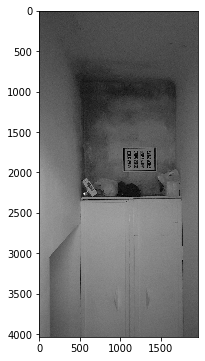

In [27]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imshow(gray, cmap='gray')

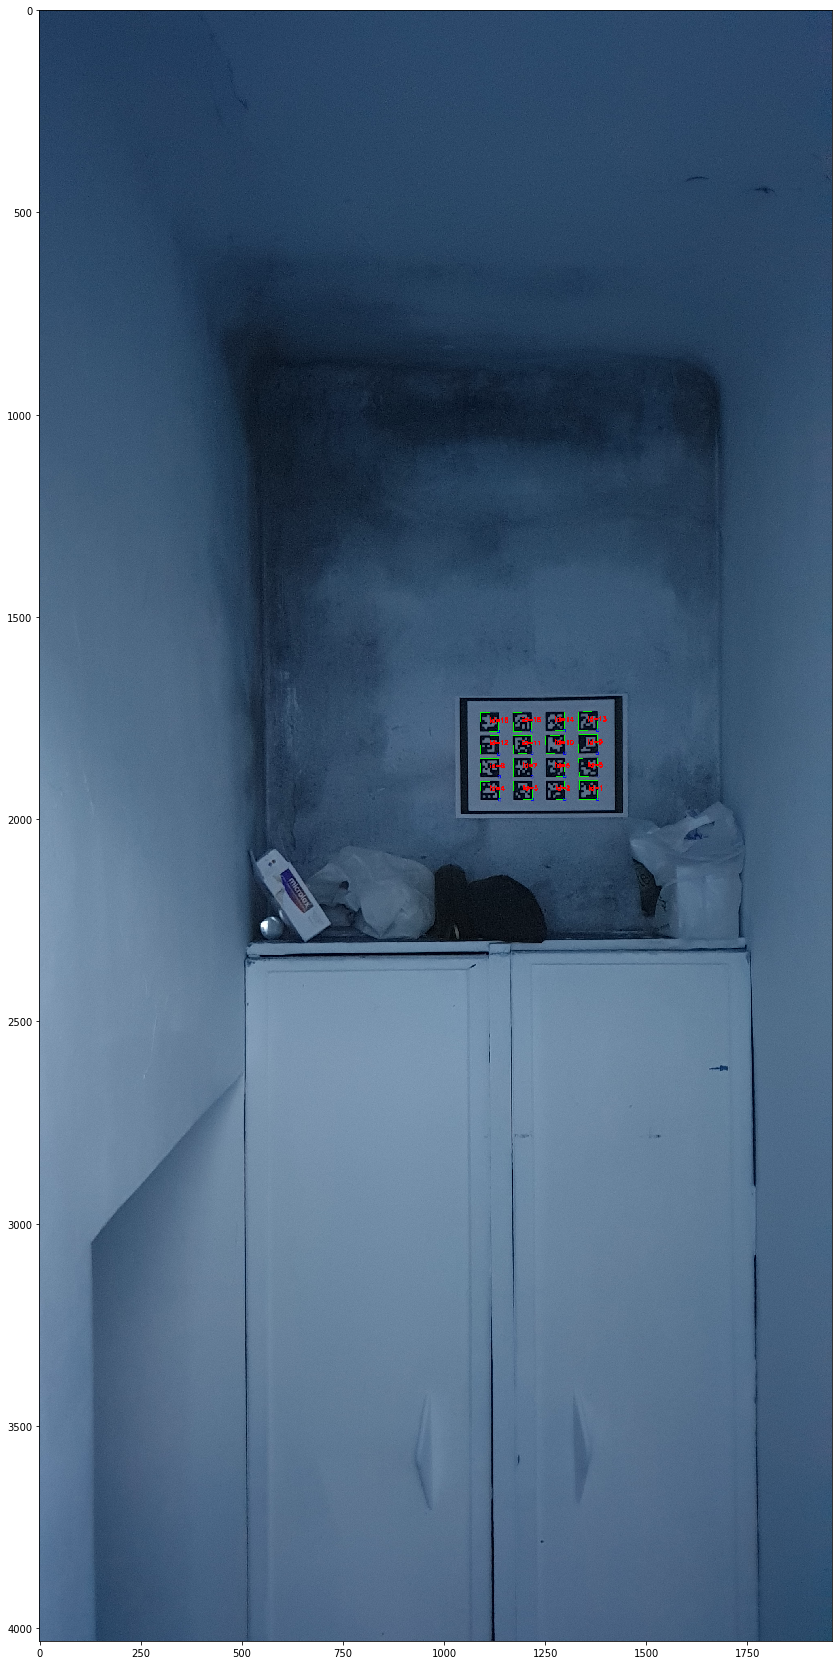

In [28]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
# We use the detectMarkers from aruco package in OpenCv to generate markers position and ids
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
# The following lines of codes are for display purpose only
frame_markers = aruco.drawDetectedMarkers(image.copy(), corners, ids)
imshow(frame_markers, (30,30))

The corners found in the image for each marker are now ordered with the `order_points` function. This function sorts the points/corners from a markers to map them as follow: `[top_left, top_right, bottom_right, bottom_left]`. Thus allowing us to generate masks from this contour.

In [29]:
# We order each contours/ corners of Aruco Markers with the order_points function
corners_ordered = [order_points(marker[0]) for marker in corners]

### SIFT detection

#### Board detection

We set an arbitrary `MIN_MATCH_COUNT` threshold to determine whether or not the SIFT detection can be relied on.

The following sequence is easily readable:
- We load the SIFT generated marker as a GRAYSCALE image
- We train our SIFT detector
- We query our previously trained SIFT detector to find the pattern in the scene

Detector Result on Train Image


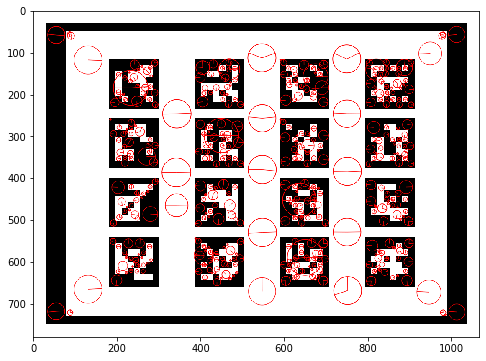

Found matches: 370


In [30]:
MIN_MATCH_COUNT = 15
enclosed_marker_train_img = cv2.imread(
    os.path.join(ROOT_FOLDER, 'markers', 'board_aruco_borders.png'),0
)
sift_detector, sift_trainKP, sift_trainDesc, flann = train_sift(enclosed_marker_train_img, compute_img=True)
sift_goodMatch, sift_queryKP, sift_queryDesc = query_sift(image.copy(), sift_detector, flann)

The more the found matches, the heavier the detection confidence. As a general rule we can assume:
- `0<=found_matches<15` **Unreliable** detection (not to be used)
- `15<=found_matches<30` **Very weak** detection (to use with caution, permissive but not accurate)
- `30<=found_matches<50` **Strong** confidence (to be used)
- `50<=found_matches` **Very Strong** confidence (to be used)

These ranges are to be considered only with regard to the training image we used. They might differ from one training image to another

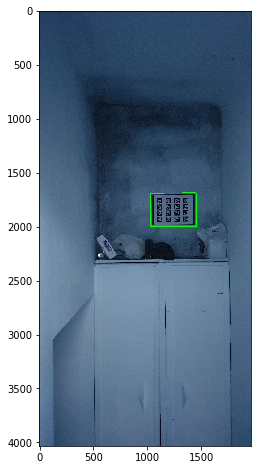

In [31]:
# Since the query has found an adequate number of matches we can compute the board corners
sift_trainBorder, sift_queryBorder_board = compute_detector_corners(
    enclosed_marker_train_img, sift_goodMatch, sift_trainKP, sift_queryKP, force_true = False
)
# Function for display purpose only
sift_detection_img = draw_detector_borders(image, sift_queryBorder_board, color=(0,255,0), thickness=5, draw=True)

#### Mask Combination & Statistics

On the following image we plot the <span style="color:green">**Board coutour**</span> and the <span style="color:red">**Marker's coutours**</span>

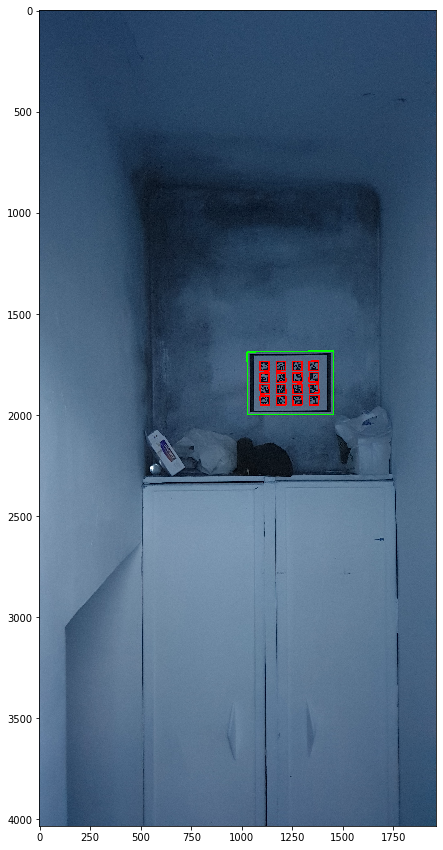

In [32]:
# Contour plotting
detector_image = image.copy()
for marker in corners:
    detector_image = draw_detector_borders(
        detector_image, 
        marker, 
        color=(255,0,0), 
        thickness=5, 
        draw=False,
    )
detector_image = draw_detector_borders(
    detector_image, 
    sift_queryBorder_board, 
    color=(0,255,0), 
    thickness=5, 
    draw=True,
    figsize=(15,15)
)

An interesting heuristic to consider, for judging if the detection is genuine, is the **Inclusion ratio** of markers inside the board (_i.e how much of the markers are deteted inside the board)_. In the **Aruco Board Case**, an Inclusion Ratio lower than 99% should be suspicious.

Since we are not looking for the same pattern between the Aruco Detection and the SIFT detector, using the Intersection over Union _(IoU)_ is irrelevant in this case.

In [33]:
marker_masks = [
    polygon_to_mask(image.shape[1], image.shape[0],marker)
    for marker in corners
]
full_markers = np.array(marker_masks).sum(axis=0)
board_mask = polygon_to_mask(image.shape[1], image.shape[0],sift_queryBorder_board)
for i in range(len(marker_masks)):
    print(f"Board Vs Marker #{i}\t\t IoU:\t {IoU(board_mask, marker_masks[i])*100}%")
    print(f" \t\t\tInclusion Ratio:\t\t {inclusion_ratio(marker_masks[i], board_mask)*100}%")

print(f"\nBoard Vs MarkerS Inclusion Ratio:\t\t {inclusion_ratio(marker_masks[i], board_mask)*100}%")

Board Vs Marker #0		 IoU:	 1.6273068560551915%
 			Inclusion Ratio:		 100.0%
Board Vs Marker #1		 IoU:	 1.6626667368848695%
 			Inclusion Ratio:		 100.0%
Board Vs Marker #2		 IoU:	 1.6280591939451847%
 			Inclusion Ratio:		 100.0%
Board Vs Marker #3		 IoU:	 1.6972742798245548%
 			Inclusion Ratio:		 100.0%
Board Vs Marker #4		 IoU:	 1.6438582896350407%
 			Inclusion Ratio:		 100.0%
Board Vs Marker #5		 IoU:	 1.610755422475342%
 			Inclusion Ratio:		 100.0%
Board Vs Marker #6		 IoU:	 1.5926993131155063%
 			Inclusion Ratio:		 100.0%
Board Vs Marker #7		 IoU:	 1.6115077603653352%
 			Inclusion Ratio:		 100.0%
Board Vs Marker #8		 IoU:	 1.610003084585349%
 			Inclusion Ratio:		 100.0%
Board Vs Marker #9		 IoU:	 1.610003084585349%
 			Inclusion Ratio:		 100.0%
Board Vs Marker #10		 IoU:	 1.6092507466953558%
 			Inclusion Ratio:		 100.0%
Board Vs Marker #11		 IoU:	 1.6611620611048834%
 			Inclusion Ratio:		 100.0%
Board Vs Marker #12		 IoU:	 1.5934516510054997%
 			Inclusion Ratio:		 100.0%

FULL MARKER


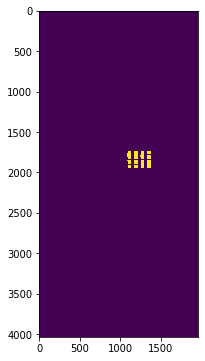

BOARD


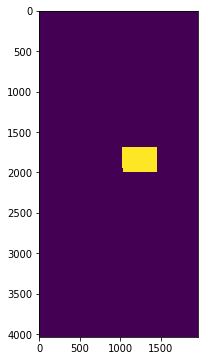

INTERSECTION & UNION


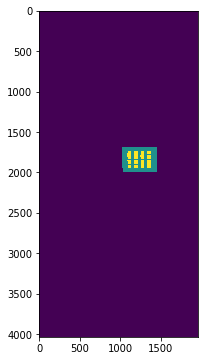

INTERSECTION


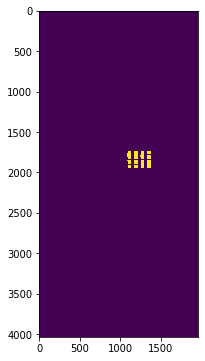

In [34]:
# We plot some analysis over the detected masks
print("FULL MARKER")
imshow(full_markers)
print("BOARD")
imshow(board_mask)
print("INTERSECTION & UNION")
imshow((full_markers + board_mask) / 2)
print("INTERSECTION")
imshow((full_markers * board_mask))

## Warp

### Board Correction

This warping only consider the **entire Board contour** and does not rely on Aruco markers or Aruco Detection.
Basically, from the ordered contour of the board we generate the two horizontal lines `[top|bottom]_left -> [top|bottom]_right` and the two vertical lines `top_[left|right] -> bottom_[left|right]` and we found their respective crossing points as vanishing points.

In [35]:
corners_ordered = order_points(sift_queryBorder_board[0])
horizontal_lines = [
    [corners_ordered[0], corners_ordered[1]],
    [corners_ordered[3], corners_ordered[2]],
]
vertical_lines = [
    [corners_ordered[3], corners_ordered[0]],
    [corners_ordered[2], corners_ordered[1]],
]
vertical_edgelets = vector_representation(vertical_lines)
horizontal_edgelets = vector_representation(horizontal_lines)
vertical_hlines = to_homogenous_geometry(*vertical_edgelets)
horizontal_hlines = to_homogenous_geometry(*horizontal_edgelets)
vp_vert = np.cross(vertical_hlines[0], vertical_hlines[1])
vp_hor = np.cross(horizontal_hlines[0], horizontal_hlines[1])
image_result = warp_image(image, vp_vert, vp_hor)

In [36]:
print(f"Warped Image Size: {image_result.shape}")
print(f"Infered Warped Image Size (If Clipping disabled): {infer_warp_shape(image, vp_vert, vp_hor)[::-1]}")

Warped Image Size: (4280, 1943, 3)
Infered Warped Image Size (If Clipping disabled): (4280, 1943)


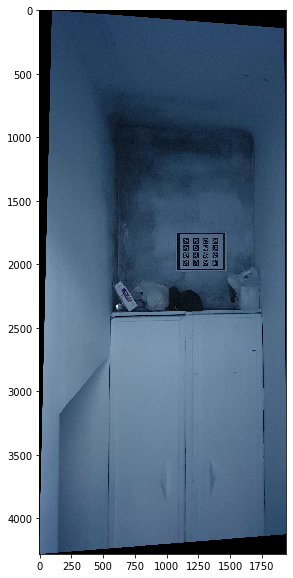

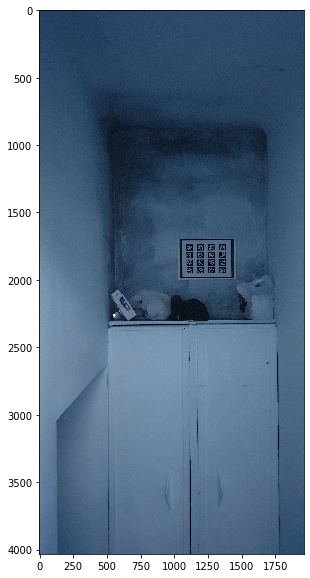

In [37]:
imshow(image_result, (10,10))
imshow(image, (10,10))

### Aruco Correction

In the case of Aruco Board Markers, we only use every horizontal and vertical lines from markers to sample vanishing points with the RANSAC algorithm.

In [61]:
corners_ordered = [order_points(marker[0]) for marker in corners]
horizontal_lines = np.array([
    [
        [marker[0], marker[1]],
        [marker[2], marker[3]],
    ]
    for marker in corners_ordered
]*20)
vertical_lines = np.array([
    [
        [marker[0], marker[3]],
        [marker[1], marker[2]],
    ]
    for marker in corners_ordered
]*20)

horizontal_lines = np.array(horizontal_lines).reshape(horizontal_lines.shape[0]*horizontal_lines.shape[1], 2, 2)
vertical_lines = np.array(vertical_lines).reshape(vertical_lines.shape[0]*vertical_lines.shape[1], 2, 2)


vertical_edgelets = vector_representation(vertical_lines)
horizontal_edgelets = vector_representation(horizontal_lines)
print("Horizontal Ransac")
vph = ransac(*horizontal_edgelets)
print("Vertical Ransac")
vpv = ransac(*vertical_edgelets)
image_result = warp_image(image, vpv, vph)

Horizontal Ransac
Current best model has 29366.9375 votes at iteration 0


/Users/walid/.local/share/virtualenvs/Pericolo-dlbZ2Y7z/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in arccos
/Users/walid/.local/share/virtualenvs/Pericolo-dlbZ2Y7z/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less


Vertical Ransac
Current best model has 28447.66015625 votes at iteration 0
Current best model has 29367.87890625 votes at iteration 1


In [62]:
print(f"Warped Image Size: {image_result.shape}")
print(f"Infered Warped Image Size (If Clipping disabled): {infer_warp_shape(image, vpv, vph)[::-1]}")

Warped Image Size: (4076, 1883, 3)
Infered Warped Image Size (If Clipping disabled): (4076, 1883)


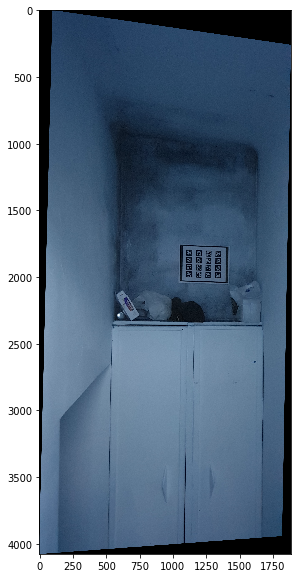

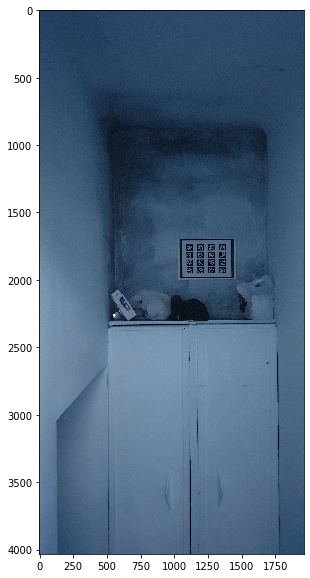

In [63]:
imshow(image_result, (10,10))
imshow(image, (10,10))

### Mixed RANSAC

To provide stronger prior knowledge, we combine board and markers contour in the RANSAC.

In [71]:
corners_ordered = [order_points(marker[0]) for marker in corners]
board_corners_ordered = order_points(sift_queryBorder_board[0])
horizontal_lines = np.array([
    [
        [marker[0], marker[1]],
        [marker[2], marker[3]],
    ]
    for marker in corners_ordered
] + [[
    [board_corners_ordered[0], board_corners_ordered[1]],
    [board_corners_ordered[3], board_corners_ordered[2]],
]])
vertical_lines = np.array([
    [
        [marker[0], marker[3]],
        [marker[1], marker[2]],
    ]
    for marker in corners_ordered
] + [[
    [board_corners_ordered[3], board_corners_ordered[0]],
    [board_corners_ordered[2], board_corners_ordered[1]],
]])

horizontal_lines = np.array(horizontal_lines).reshape(horizontal_lines.shape[0]*horizontal_lines.shape[1], 2, 2)
vertical_lines = np.array(vertical_lines).reshape(vertical_lines.shape[0]*vertical_lines.shape[1], 2, 2)


vertical_edgelets = vector_representation(vertical_lines)
horizontal_edgelets = vector_representation(horizontal_lines)
print("Horizontal Ransac")
vph = ransac(*horizontal_edgelets)
print("Vertical Ransac")
vpv = ransac(*vertical_edgelets)
image_result = warp_image(image, vpv, vph)

Horizontal Ransac
Current best model has 2272.47607421875 votes at iteration 1
Current best model has 2318.48681640625 votes at iteration 7
Vertical Ransac
Current best model has 2091.048583984375 votes at iteration 0


/Users/walid/.local/share/virtualenvs/Pericolo-dlbZ2Y7z/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in arccos
/Users/walid/.local/share/virtualenvs/Pericolo-dlbZ2Y7z/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less


In [72]:
print(f"Warped Image Size: {image_result.shape}")
print(f"Infered Warped Image Size (If Clipping disabled): {infer_warp_shape(image, vpv, vph)[::-1]}")

Warped Image Size: (2836, 1639, 3)
Infered Warped Image Size (If Clipping disabled): (2836, 1639)


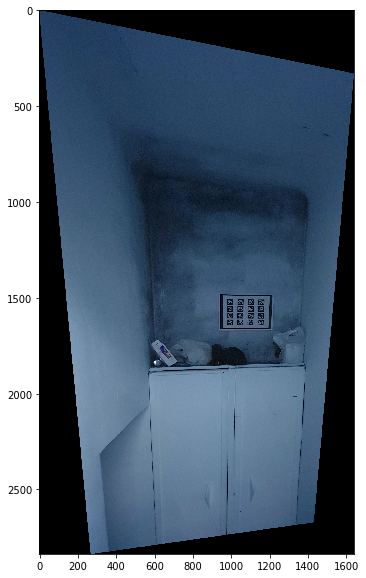

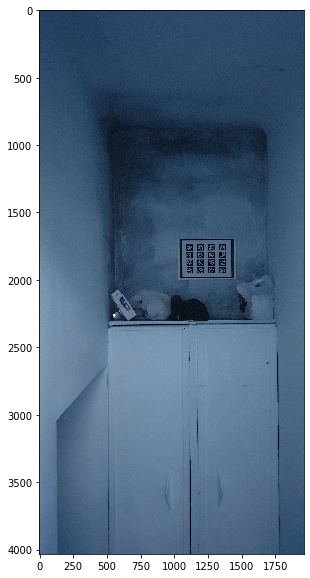

In [73]:
imshow(image_result, (10,10))
imshow(image, (10,10))

# Appendix